In [44]:
%load_ext autoreload
%autoreload 2

from dataset.BRT_Dataset import BRT_Dataset, MEAN_VAL_FUNC, STD_VAL_FUNC, MEAN_ENV_GRID, STD_ENV_GRID
import torch
from torch.utils.data import Dataset
import numpy as np
import os
import pandas as pd
from loguru import logger
import matplotlib.pyplot as plt
from skimage import measure
from scipy import ndimage
from diffusion.Diffusion import Diffusion

MEAN_ENV_GRID = torch.from_numpy(MEAN_ENV_GRID)
STD_ENV_GRID = torch.from_numpy(STD_ENV_GRID)
MEAN_VAL_FUNC = torch.from_numpy(MEAN_VAL_FUNC)
STD_VAL_FUNC = torch.from_numpy(STD_VAL_FUNC)

padded_grid_size = None
split = "train"
dataset = BRT_Dataset(data_dir="/Users/johncao/Documents/Programming/Stanford/AA276/project/dataset_64",
                        split=split,
                        padded_grid_size=padded_grid_size,
                        device="cpu")

2025-05-18 11:00:50.952 | INFO     | dataset.BRT_Dataset:__init__:14 - Loaded 479 BRT samples.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
def plot_value_function(tensor, threshold=0, x_interval=None, y_interval=None, z_interval=None):
    # Create figure and 3D axis
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get coordinates where values are negative
    x_indices, y_indices, z_indices = np.where(tensor < threshold)
    values = tensor[x_indices, y_indices, z_indices]
    
    # Map indices to custom intervals if provided
    x_coords = x_indices.copy()
    y_coords = y_indices.copy()
    z_coords = z_indices.copy()
    
    if x_interval is not None:
        # Transform x indices to the specified interval
        x_min, x_max = x_interval
        x_size = tensor.shape[0] - 1  # Max index value
        x_coords = x_min + (x_indices / x_size) * (x_max - x_min)
    
    if y_interval is not None:
        # Transform y indices to the specified interval
        y_min, y_max = y_interval
        y_size = tensor.shape[1] - 1  # Max index value
        y_coords = y_min + (y_indices / y_size) * (y_max - y_min)
    
    if z_interval is not None:
        # Transform z indices to the specified interval
        z_min, z_max = z_interval
        z_size = tensor.shape[2] - 1  # Max index value
        z_coords = z_min + (z_indices / z_size) * (z_max - z_min)
    
    # Normalize the values for coloring
    if len(values) > 0:
        norm = plt.Normalize(values.min(), threshold)
        colors = plt.cm.coolwarm(norm(values))
        
        # Plot scatter points for negative values using the mapped coordinates
        scatter = ax.scatter(x_coords, y_coords, z_coords, 
                   c=values, cmap='coolwarm', alpha=0.8, 
                   s=50, edgecolor='none')
        
        # Add a colorbar
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
        cbar.set_label('Value')
        
        # Set labels and title
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
        ax.set_title('Negative Values in 3D Tensor (Values < {})'.format(threshold))
        
        plt.tight_layout()
        plt.show()
    else:
        print("No negative values found in the tensor.")

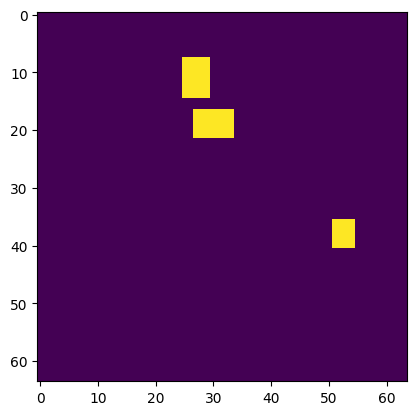

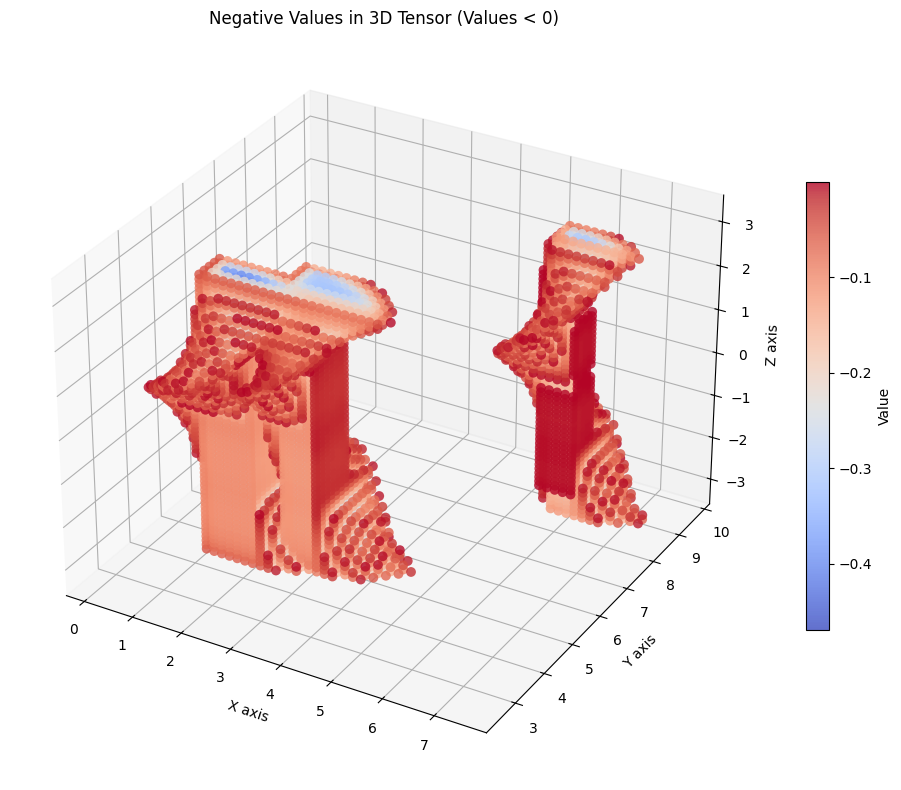

In [46]:
ind = 143
val_func, env_grid = dataset[ind]

fig = plt.figure()
plt.imshow(env_grid.squeeze(0))
plt.show()

val_func_denorm = val_func*STD_VAL_FUNC + MEAN_VAL_FUNC

val_func_denorm = val_func_denorm.permute(1, 2, 0)

plot_value_function(val_func_denorm,
                    x_interval=(0, 10),
                    y_interval=(0, 10),
                    z_interval=(-np.pi, np.pi))


In [47]:
def plot_value_function_batch(batch_tensor, time, threshold=0, x_interval=None, y_interval=None, z_interval=None, 
                             grid_cols=6, figsize=(12, 6)):
    """
    Plot a batch of 3D tensors in a grid layout.
    
    Parameters:
    -----------
    batch_tensor : torch.Tensor
        Batch of 3D tensors with shape (B, C, H, W) where B is batch size
    threshold : float
        Threshold value for displaying points (values < threshold are plotted)
    x_interval, y_interval, z_interval : tuple of (min, max) or None
        Custom intervals for mapping indices
    grid_cols : int
        Number of columns in the grid
    figsize : tuple
        Figure size (width, height) in inches
    """
    # Convert to numpy if it's a torch tensor
    if torch.is_tensor(batch_tensor):
        batch_tensor_np = batch_tensor.detach().cpu().numpy()
    else:
        batch_tensor_np = batch_tensor
        
    batch_size = batch_tensor_np.shape[0]
    grid_rows = (batch_size + grid_cols - 1) // grid_cols  # Calculate needed rows
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    
    # Loop through each tensor in the batch
    for i in range(batch_size):
        tensor = batch_tensor_np[i]
        
        # Create 3D subplot
        ax = fig.add_subplot(grid_rows, grid_cols, i+1, projection='3d')
        
        # Get coordinates where values are negative
        x_indices, y_indices, z_indices = np.where(tensor < threshold)
        values = tensor[x_indices, y_indices, z_indices]
        
        # Map indices to custom intervals if provided
        x_coords = x_indices.copy()
        y_coords = y_indices.copy()
        z_coords = z_indices.copy()
        
        if x_interval is not None:
            # Transform x indices to the specified interval
            x_min, x_max = x_interval
            x_size = tensor.shape[0] - 1  # Max index value
            x_coords = x_min + (x_indices / x_size) * (x_max - x_min)
        
        if y_interval is not None:
            # Transform y indices to the specified interval
            y_min, y_max = y_interval
            y_size = tensor.shape[1] - 1  # Max index value
            y_coords = y_min + (y_indices / y_size) * (y_max - y_min)
        
        if z_interval is not None:
            # Transform z indices to the specified interval
            z_min, z_max = z_interval
            z_size = tensor.shape[2] - 1  # Max index value
            z_coords = z_min + (z_indices / z_size) * (z_max - z_min)
        
        # Normalize the values for coloring
        if len(values) > 0:
            norm = plt.Normalize(values.min(), threshold)
            
            # Plot scatter points for negative values using the mapped coordinates
            scatter = ax.scatter(x_coords, y_coords, z_coords, 
                       c=values, cmap='Spectral', alpha=0.8, 
                       s=25, edgecolor='none')  # Smaller point size for grid plots
            
            # Set labels
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('$\\theta$')
            ax.set_title(f't = {time[i]+1}')
            
        else:
            ax.text(0.5, 0.5, 0.5, "No values < threshold", 
                   horizontalalignment='center', verticalalignment='center')
    
    # Add a single colorbar for the entire figure - using PyTorch compatible check
    has_values_below_threshold = (batch_tensor_np < threshold).any()
    if has_values_below_threshold:
        cbar_ax = fig.add_axes([0.97, 0.30, 0.02, 0.4])  # Position for colorbar
        # Get all values below threshold
        all_values = batch_tensor_np[batch_tensor_np < threshold]
        norm = plt.Normalize(all_values.min(), threshold)
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Spectral'), cax=cbar_ax)
        cbar.set_label('Value')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, right=0.9)  # Adjust for colorbar
    plt.show()

/var/folders/m1/1f35zp991ps2ljq0vpr6qr4h0000gn/T/ipykernel_72549/2423387197.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


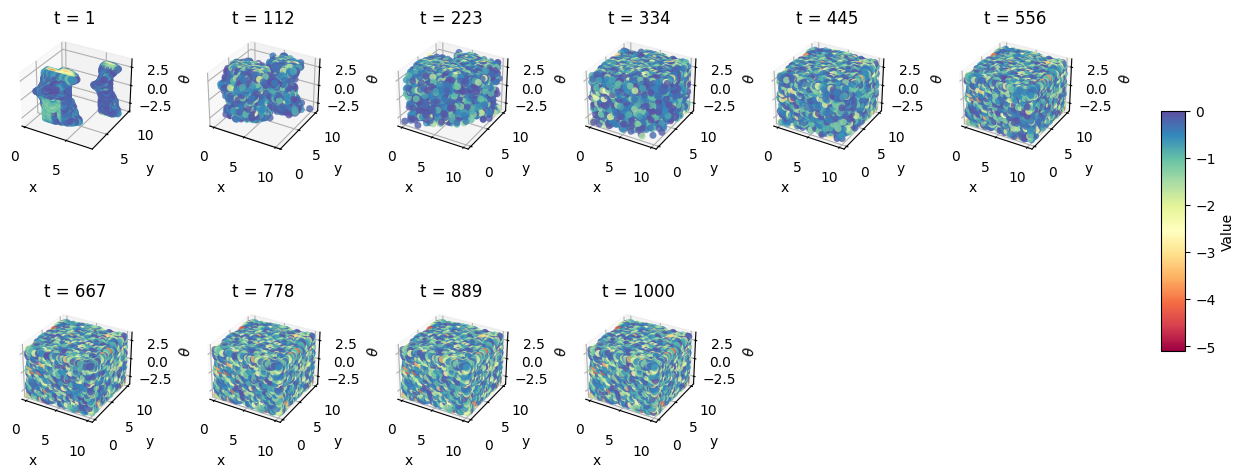

In [48]:
noise_steps = 1000
diffusion = Diffusion(img_size=64, beta_end=0.02, noise_steps=noise_steps, device="cpu")

num_samples = 10
t = torch.linspace(0, noise_steps-1, num_samples, dtype=torch.int64)



noised_brt, noise = diffusion.noise_images(val_func.unsqueeze(0), t)

for i in range(num_samples):
    noised_brt[i] = noised_brt[i]*STD_VAL_FUNC + MEAN_VAL_FUNC

plot_value_function_batch(noised_brt.permute(0,2,3,1),
                          t,
                    x_interval=(0, 10),
                    y_interval=(0, 10),
                    z_interval=(-np.pi, np.pi))

/var/folders/m1/1f35zp991ps2ljq0vpr6qr4h0000gn/T/ipykernel_72549/2423387197.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


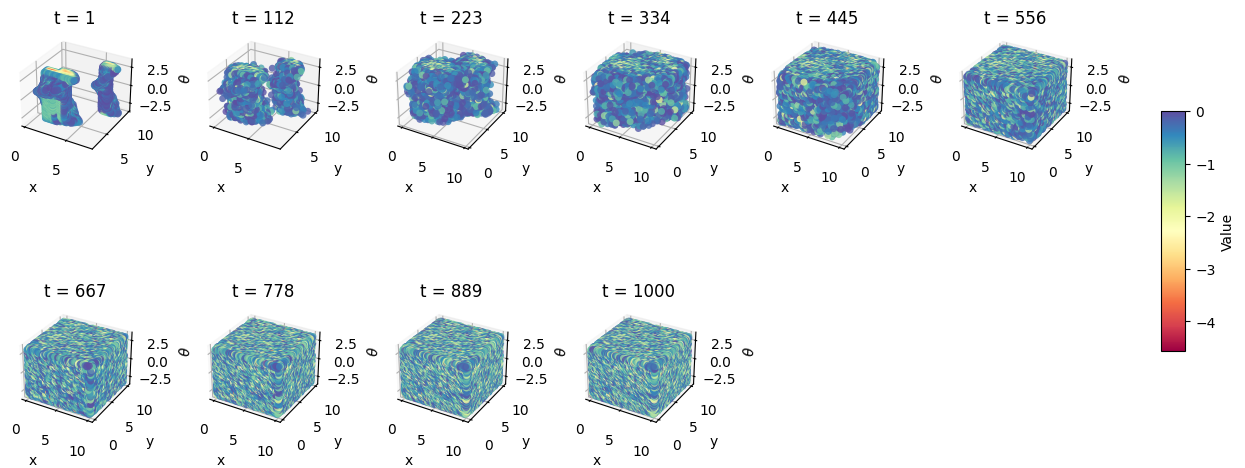

In [37]:
tnoise_steps = 1000
diffusion = Diffusion(img_size=64, noise_steps=noise_steps, device="cpu")

num_samples = 10
t = torch.linspace(0, noise_steps-1, num_samples, dtype=torch.int64)



noised_brt, noise = diffusion.noise_images(val_func_denorm.permute(2,0,1).unsqueeze(0), t)

# for i in range(num_samples):
#     noised_brt[i] = noised_brt[i]*STD_VAL_FUNC + MEAN_VAL_FUNC

plot_value_function_batch(noised_brt.permute(0,2,3,1),
                          t,
                    x_interval=(0, 10),
                    y_interval=(0, 10),
                    z_interval=(-np.pi, np.pi))